### Simplified attention

#### Visualise data

In [4]:
with open("data/the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()
    
print("Total number of character:", len(raw_text))
print(raw_text[:99])

Total number of character: 20479
I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


In [1]:
import torch

inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)

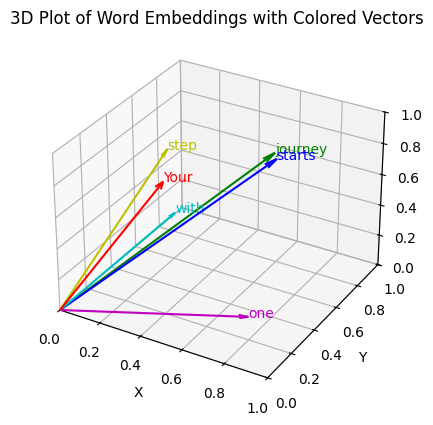

In [5]:
# Create 3D plot with vectors from origin to each point, using different colors
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Define a list of colors for the vectors
colors = ['r', 'g', 'b', 'c', 'm', 'y']

# Plot each vector with a different color and annotate with the corresponding word
for (x, y, z, word, color) in zip(x_coords, y_coords, z_coords, words, colors):
    # Draw vector from origin to the point (x, y, z) with specified color and smaller arrow length ratio
    ax.quiver(0, 0, 0, x, y, z, color=color, arrow_length_ratio=0.05)
    ax.text(x, y, z, word, fontsize=10, color=color)

# Set labels for axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Set plot limits to keep arrows within the plot boundaries
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_zlim([0, 1])

plt.title('3D Plot of Word Embeddings with Colored Vectors')
plt.show()


#### Calculate context vector with attention weights

Lets focus on x^2. This is called as query<br>
**First task:** Compute the intermidiate values w<br>
**w =** How much attention should be paid to each of the other words for the query. This is called attention score
**w =** Dot product of x and w

In [6]:
query = inputs[1]  # 2nd input token is the query

attn_scores_2 = torch.empty(inputs.shape[0])
for i, x_i in enumerate(inputs):
    attn_scores_2[i] = torch.dot(x_i, query) # dot product (transpose not necessary here since they are 1-dim vectors)

print(attn_scores_2)

tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])


**Normalize the attention scores** Consider one token now

In [7]:
attn_weights_2_tmp = attn_scores_2 / attn_scores_2.sum()

print("Attention weights:", attn_weights_2_tmp)
print("Sum:", attn_weights_2_tmp.sum())

Attention weights: tensor([0.1455, 0.2278, 0.2249, 0.1285, 0.1077, 0.1656])
Sum: tensor(1.0000)


**In practice, it's more common and advisable to use the softmax function for normalization.**<br>
This approach is better at managing extreme values and offers more favorable gradient<br>

In [8]:
def softmax_naive(x):
    return torch.exp(x) / torch.exp(x).sum(dim=0)

attn_weights_2_naive = softmax_naive(attn_scores_2)

print("Attention weights:", attn_weights_2_naive)
print("Sum:", attn_weights_2_naive.sum())

Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)


**Pytorch implementation of softmax**

In [9]:
attn_weights_2 = torch.softmax(attn_scores_2, dim=0)
print("Attention weights:", attn_weights_2)
print("Sum:", attn_weights_2.sum())

Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)


**Calulate the attention scores for all the tokens**

In [10]:
attn_scores = torch.empty(6, 6)

for i, x_i in enumerate(inputs):
    for j, x_j in enumerate(inputs):
        attn_scores[i, j] = torch.dot(x_i, x_j)

print(attn_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


**one lienr implementation**

In [11]:
attn_scores = inputs @ inputs.T
print(attn_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


**Calculate attention weights**<br>
dim=-1, we are instructing the softmax function to apply the normalization along the last
dimension of the attn_scores tensor. <br>
This is the diamention of the input function - here dim=-1 will normalise across the columns, means the input to softmax is one rowat a time

In [12]:
attn_weights = torch.softmax(attn_scores, dim=-1)
print(attn_weights)

tensor([[0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452],
        [0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581],
        [0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565],
        [0.1435, 0.2074, 0.2046, 0.1462, 0.1263, 0.1720],
        [0.1526, 0.1958, 0.1975, 0.1367, 0.1879, 0.1295],
        [0.1385, 0.2184, 0.2128, 0.1420, 0.0988, 0.1896]])


**Use these attention weights to compute all context vectors via matrix multiplication**

In [13]:
all_context_vecs = attn_weights @ inputs
print(all_context_vecs)

tensor([[0.4421, 0.5931, 0.5790],
        [0.4419, 0.6515, 0.5683],
        [0.4431, 0.6496, 0.5671],
        [0.4304, 0.6298, 0.5510],
        [0.4671, 0.5910, 0.5266],
        [0.4177, 0.6503, 0.5645]])


#### Calculate context vector with trainable weights

**Initialize Query, Key and Value matrix**

In [32]:
x_2 = inputs[1] #A
d_in = inputs.shape[1] #B
d_out = 2 #C

Note that we are setting requires_grad=False to reduce clutter in the outputs for
illustration purposes. <br>

If we were to use the weight matrices for model training, we
would set requires_grad=True to update these matrices during model training.

In [33]:
torch.manual_seed(123)
W_query = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_key = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_value = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)

In [34]:
query_2 = x_2 @ W_query
key_2 = x_2 @ W_key
value_2 = x_2 @ W_value
print(query_2)

tensor([0.4306, 1.4551])


**Obtain all keys and values via matrix multiplication**

In [35]:
query = inputs @ W_query
keys = inputs @ W_key
values = inputs @ W_value
print("keys.shape:", query.shape)
print("keys.shape:", keys.shape)
print("values.shape:", values.shape)

keys.shape: torch.Size([6, 2])
keys.shape: torch.Size([6, 2])
values.shape: torch.Size([6, 2])


**Compute the attention score ω22**

In [36]:
keys_2 = keys[1] #A
attn_score_22 = query_2.dot(keys_2)
print(attn_score_22)

tensor(1.8524)


In [37]:
attn_scores_2 = query_2 @ keys.T # All attention scores for given query
print(attn_scores_2)

tensor([1.2705, 1.8524, 1.8111, 1.0795, 0.5577, 1.5440])


**Get attention scores for all the words/tokens**

In [44]:
attn_scores = query @ keys.T
attn_scores

tensor([[0.9231, 1.3545, 1.3241, 0.7910, 0.4032, 1.1330],
        [1.2705, 1.8524, 1.8111, 1.0795, 0.5577, 1.5440],
        [1.2544, 1.8284, 1.7877, 1.0654, 0.5508, 1.5238],
        [0.6973, 1.0167, 0.9941, 0.5925, 0.3061, 0.8475],
        [0.6114, 0.8819, 0.8626, 0.5121, 0.2707, 0.7307],
        [0.8995, 1.3165, 1.2871, 0.7682, 0.3937, 1.0996]])

**Compute Attention weights**<br>
To make the interpretation, compute normalisation<br>
In this case scale by sqrt(d) then apply softmax

In [47]:
attn_weights = attn_scores/(keys.shape[-1]**0.5)
attn_weights

tensor([[0.6528, 0.9578, 0.9363, 0.5593, 0.2851, 0.8011],
        [0.8984, 1.3098, 1.2806, 0.7633, 0.3944, 1.0918],
        [0.8870, 1.2929, 1.2641, 0.7534, 0.3895, 1.0775],
        [0.4930, 0.7189, 0.7029, 0.4190, 0.2164, 0.5993],
        [0.4323, 0.6236, 0.6099, 0.3621, 0.1914, 0.5167],
        [0.6361, 0.9309, 0.9101, 0.5432, 0.2784, 0.7776]])

In [48]:
attn_weights = torch.softmax(attn_weights, dim=-1)
print(attn_weights)

tensor([[0.1551, 0.2104, 0.2059, 0.1413, 0.1074, 0.1799],
        [0.1500, 0.2264, 0.2199, 0.1311, 0.0906, 0.1820],
        [0.1503, 0.2256, 0.2192, 0.1315, 0.0914, 0.1819],
        [0.1591, 0.1994, 0.1962, 0.1477, 0.1206, 0.1769],
        [0.1610, 0.1949, 0.1923, 0.1501, 0.1265, 0.1752],
        [0.1557, 0.2092, 0.2048, 0.1419, 0.1089, 0.1794]])


**Compute the context vector**

In [49]:
all_context_vecs = attn_weights @ values
print(all_context_vecs)

tensor([[0.2996, 0.8053],
        [0.3061, 0.8210],
        [0.3058, 0.8203],
        [0.2948, 0.7939],
        [0.2927, 0.7891],
        [0.2990, 0.8040]])


### IMPLEMENTING A COMPACT SELF ATTENTION PYTHON CLASS

In [50]:
import torch.nn as nn

class SelfAttention_v1(nn.Module):

    def __init__(self, d_in, d_out):
        super().__init__()
        self.W_query = nn.Parameter(torch.rand(d_in, d_out))
        self.W_key   = nn.Parameter(torch.rand(d_in, d_out))
        self.W_value = nn.Parameter(torch.rand(d_in, d_out))

    def forward(self, x):
        keys = x @ self.W_key
        queries = x @ self.W_query
        values = x @ self.W_value
        
        attn_scores = queries @ keys.T # omega
        attn_weights = torch.softmax(
            attn_scores / keys.shape[-1]**0.5, dim=-1
        )

        context_vec = attn_weights @ values
        return context_vec

In [51]:
torch.manual_seed(123)
sa_v1 = SelfAttention_v1(d_in, d_out)
print(sa_v1(inputs))

tensor([[0.2996, 0.8053],
        [0.3061, 0.8210],
        [0.3058, 0.8203],
        [0.2948, 0.7939],
        [0.2927, 0.7891],
        [0.2990, 0.8040]], grad_fn=<MmBackward0>)


We can improve the SelfAttention_v1 implementation further by utilizing PyTorch's
nn.Linear layers, which effectively perform matrix multiplication when the bias units are
disabled. <br>
Additionally, a significant advantage of using nn.Linear instead of manually
implementing nn.Parameter(torch.rand(...)) is that nn.Linear has an optimized weight
initialization scheme, contributing to more stable and effective model training.

In [52]:
class SelfAttention_v2(nn.Module):

    def __init__(self, d_in, d_out, qkv_bias=False):
        super().__init__()
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key   = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

    def forward(self, x):
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)
        
        attn_scores = queries @ keys.T
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)

        context_vec = attn_weights @ values
        return context_vec

In [53]:
torch.manual_seed(789)
sa_v2 = SelfAttention_v2(d_in, d_out)
print(sa_v2(inputs))

tensor([[-0.0739,  0.0713],
        [-0.0748,  0.0703],
        [-0.0749,  0.0702],
        [-0.0760,  0.0685],
        [-0.0763,  0.0679],
        [-0.0754,  0.0693]], grad_fn=<MmBackward0>)


### Causal attention

**Reuse the query and key weight matrices of the SelfAttention_v2 object from the previous section for
convenience**

**Implemention using torch function**<br>
The softmax function converts its inputs into a probability distribution. <br>
When negative infinity values (-∞) are present in a row, the softmax function treats them as zero probability. <br>
(Mathematically, this is because e -∞ approaches 0.)<br>
We can implement this more efficient masking "trick" by creating a mask with 1's above
the diagonal and then replacing these 1's with negative infinity (-inf) values:

In [58]:
mask = torch.triu(torch.ones(context_length, context_length), diagonal=1)
masked = attn_scores.masked_fill(mask.bool(), -torch.inf)
print(masked)

tensor([[0.2899,   -inf,   -inf,   -inf,   -inf,   -inf],
        [0.4656, 0.1723,   -inf,   -inf,   -inf,   -inf],
        [0.4594, 0.1703, 0.1731,   -inf,   -inf,   -inf],
        [0.2642, 0.1024, 0.1036, 0.0186,   -inf,   -inf],
        [0.2183, 0.0874, 0.0882, 0.0177, 0.0786,   -inf],
        [0.3408, 0.1270, 0.1290, 0.0198, 0.1290, 0.0078]],
       grad_fn=<MaskedFillBackward0>)


Apply the softmax function to these masked results

In [59]:
attn_weights = torch.softmax(masked / keys.shape[-1]**0.5, dim=1)
print(attn_weights)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4483, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3800, 0.3097, 0.3103, 0.0000, 0.0000, 0.0000],
        [0.2758, 0.2460, 0.2462, 0.2319, 0.0000, 0.0000],
        [0.2175, 0.1983, 0.1984, 0.1888, 0.1971, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<SoftmaxBackward0>)


**MASKING ADDITIONAL ATTENTION WEIGHTS WITH DROPOUT**<br>
Improves generalization
This dropout is applied in 2 specific area
1. After calculating attention scores
2. After applying attention weights to value vectors

In [60]:
torch.manual_seed(123)
dropout = torch.nn.Dropout(0.5) #A
example = torch.ones(6, 6) #B
print(dropout(example))

tensor([[2., 2., 0., 2., 2., 0.],
        [0., 0., 0., 2., 0., 2.],
        [2., 2., 2., 2., 0., 2.],
        [0., 2., 2., 0., 0., 2.],
        [0., 2., 0., 2., 0., 2.],
        [0., 2., 2., 2., 2., 0.]])


In [61]:
torch.manual_seed(123)
print(dropout(attn_weights))

tensor([[2.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.7599, 0.6194, 0.6206, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.4921, 0.4925, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.3966, 0.0000, 0.3775, 0.0000, 0.0000],
        [0.0000, 0.3327, 0.3331, 0.3084, 0.3331, 0.0000]],
       grad_fn=<MulBackward0>)


**IMPLEMENTING A COMPACT CAUSAL ATTENTION CLASS**

In [63]:
batch = torch.stack((inputs, inputs), dim=0)
print(batch.shape) 

torch.Size([2, 6, 3])


In [ ]:
class CausalAttention(nn.Module):

    def __init__(self, d_in, d_out, context_length,
                 dropout, qkv_bias=False):
        super().__init__()
        self.d_out = d_out
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key   = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.dropout = nn.Dropout(dropout) # New
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1)) # Buffers are automatically moved to the appropriate device(CPU or GPU)

    def forward(self, x):
        b, num_tokens, d_in = x.shape # New batch dimension b
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        attn_scores = queries @ keys.transpose(1, 2) # Changed transpose
        attn_scores.masked_fill_(  # New, _ ops are in-place
            self.mask.bool()[:num_tokens, :num_tokens], -torch.inf)  # `:num_tokens` to account for cases where the number of tokens in the batch is smaller than the supported context_size
        attn_weights = torch.softmax(
            attn_scores / keys.shape[-1]**0.5, dim=-1
        )
        attn_weights = self.dropout(attn_weights) # New

        context_vec = attn_weights @ values
        return context_vec

Use the CausalAttention class as follows, similar to SelfAttention previously

In [64]:
torch.manual_seed(123)
context_length = batch.shape[1]
ca = CausalAttention(d_in, d_out, context_length, 0.0)
context_vecs = ca(batch)
print("context_vecs.shape:", context_vecs.shape)

context_vecs.shape: torch.Size([2, 6, 2])


### Multihead attention